# Итерационные методы
## Фёдор Гарбузов*, Елизавета Душенкова
(*) fedor.garbuzov@gmail.com

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [3]:
import numpy as np
from problemlib.elliptic import *
import pandas as pd

In [4]:
print("(depth, mesh side (M = N)):")
s = 4
for i in range(10):
    s *= 2
    s -= 1
    print(1 + i, s)

(depth, mesh side (M = N)):
1 7
2 13
3 25
4 49
5 97
6 193
7 385
8 769
9 1537
10 3073


In [26]:
xlim = np.array([0, np.pi])
ylim = np.array([0, np.pi])
M, N = 49, 49
prec = 1e-4
depth = 4
mg_it = 1
smooth_it = 2
problem = EllipticProblem(M, N, xlim, ylim)

<IPython.core.display.Javascript object>


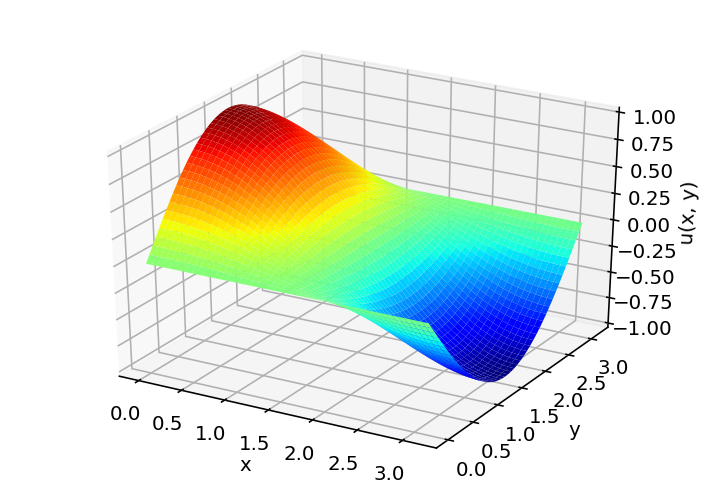

In [27]:
X, Y = np.meshgrid(problem.mesh.X, problem.mesh.Y)
fig = plt.figure(figsize=[5,3.5])
ax = Axes3D(fig)
ax.plot_surface(X, Y, np.sin(Y)*np.cos(X), cmap=cm.jet)
ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('u(x, y)')
ax.dist = 11
fig.show()
fig.savefig('sln_plot.png')

In [15]:
err, sr, it = problem.solve(it_num=1000)

In [16]:
problem.error()

0.0009471429697556845

In [17]:
s = np.linalg.solve(problem.full_matrix(), problem.right)

In [18]:
problem.sln = s
problem.error()

8.692572912453458e-05

In [19]:
sln, err, it = problem.solve_multigrid(depth, mg_it, smooth_it, smooth_it, it_num=10, smooth_m='seidel')

# 2. Влияние метода сглаживания и числа сглаживающих итераций

In [28]:
import time as tm

In [29]:
df = pd.DataFrame(columns=['smooth', 'sei_i', 'sei_t', 'jac_i', 'jac_t', 'sor_i', 'sor_t'])

In [30]:
problem = EllipticProblem(M, N, xlim, ylim)

In [31]:
sln, err, it = problem.solve(it_num=200)

In [32]:
err[-10:]

[0.9865258503001061,
 0.9865467252917969,
 0.9865682038614667,
 0.986590291856608,
 0.9866129949505987,
 0.986636318634061,
 0.9866602682061728,
 0.986684848765576,
 0.9867100652011481,
 0.9867359221828059]

In [33]:
for smooth_it in range(1, 8):
    problem.sln = np.zeros_like(problem.sln)
    start = tm.clock()
    sln_mg_sei, err_mg_sei, sr = problem.solve_multigrid(depth, mg_it, smooth_it, smooth_it, 
                                                         eps=prec, smooth_m='seidel')
    time_sei = tm.clock()
    time_sei -= start
    
    problem.sln = np.zeros_like(problem.sln)
    start = tm.clock()
    sln_mg_jac, err_mg_jac, sr = problem.solve_multigrid(depth, mg_it, smooth_it, smooth_it, 
                                                         eps=prec, smooth_m='jacobi')
    time_jac = tm.clock()
    time_jac -= start
    
    problem.sln = np.zeros_like(problem.sln)
    start = tm.clock()
    sln_mg_sor, err_mg_sor, sr = problem.solve_multigrid(depth, mg_it, smooth_it, smooth_it, 
                                                         eps=prec, smooth_m='sor')
    time_sor = tm.clock()
    time_sor -= start
    
    df = df.append(pd.DataFrame({'smooth': smooth_it, 'sei_i': len(err_mg_sei), 'sei_t': time_sei,
                                 'jac_i': len(err_mg_jac), 'jac_t': time_jac,
                                 'sor_i': len(err_mg_sor), 'sor_t': time_sor}, [0]), ignore_index=True)

In [34]:
df

,jac_i,jac_t,sei_i,sei_t,smooth,sor_i,sor_t
0,11,0.976889,8,0.594340,1,12,0.878482
1,7,0.890177,6,0.678693,2,7,0.684140
2,6,1.127725,5,0.665803,3,5,0.936051
3,6,1.179253,5,0.767365,4,5,0.775964
4,5,1.155866,4,0.582682,5,4,0.638988
5,5,1.345615,4,0.624398,6,4,0.731769
6,5,1.555754,4,0.666739,7,4,0.883768


In [ ]:
df.to_csv('smooth_research.csv', index=False)

## Иллюстрация сглаживания

In [4]:
smooth_it = 3

In [5]:
problem.sln = np.zeros_like(problem.sln)
sln_mg, err_mg, sr = problem.solve_multigrid(depth, mg_it, prec, smooth_it, smooth_it, 'seidel')

In [6]:
func = []
for i in range(smooth_it + 1):
    f = np.load(str(i) + '_seidel.npy')
    func.append(f)

<IPython.core.display.Javascript object>


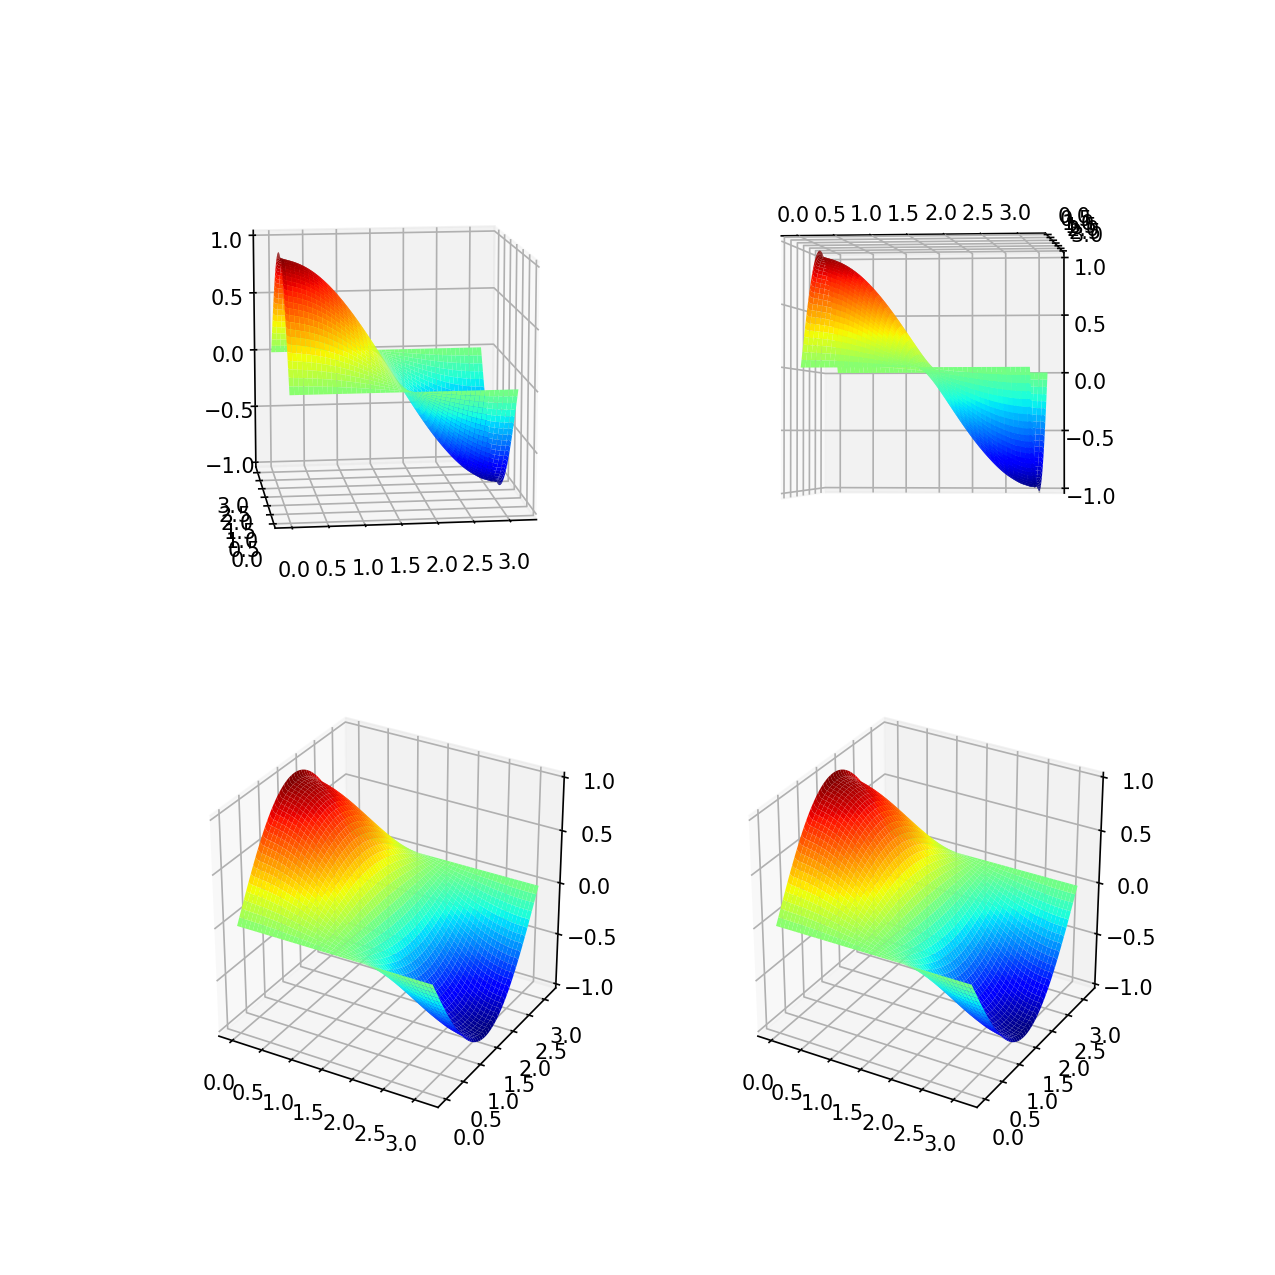

In [9]:
fig = plt.figure(figsize=[8.5,8.5])
M_s, N_s = M, N
x = np.linspace(xlim[0], xlim[1], M_s)
y = np.linspace(ylim[0], ylim[1], N_s)
for i in range(smooth_it + 1):
    ax = fig.add_subplot(2, 2, 1 + i, projection='3d')
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, np.transpose(func[i].reshape([M_s, N_s])), cmap=cm.jet)

In [20]:
len(Y)

385

<IPython.core.display.Javascript object>


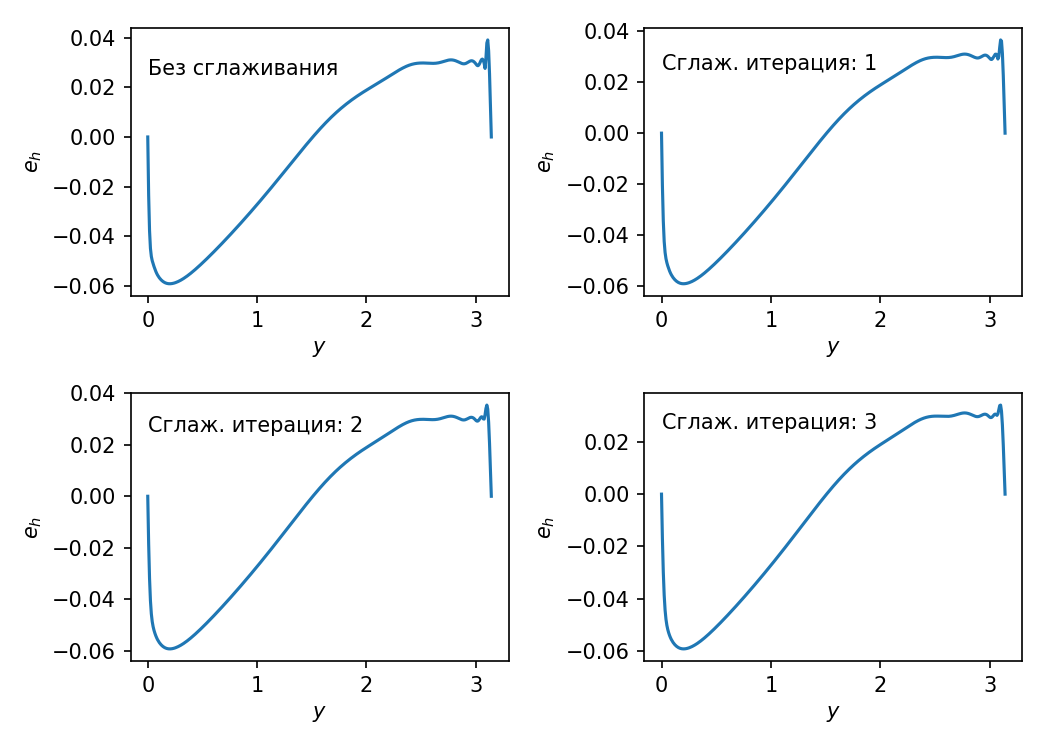

In [34]:
fig = plt.figure(figsize=[7,5])
M_s = M
Y = np.linspace(ylim[0], ylim[1], M_s)
for i in range(smooth_it + 1):
    plt.subplot(2, 2, 1 + i)
    plt.plot(Y, (func[i].reshape([M_s, M_s]) - problem.exact_sln_matrix())[:, int(M_s/2)])
    #plt.grid()
    plt.xlabel('$y$'), plt.ylabel('$e_h$')
    if i == 0:
        plt.text(0, 0.025, 'Без сглаживания')
    else:
        plt.text(0, 0.025, 'Сглаж. итерация: ' + str(i))
        #plt.text(2.99, -0.99, 'Сглаж. итерация: ' + str(i))
    plt.tight_layout()
plt.savefig('smooth_glob.png')

# 3. Влияние числа узлов

In [ ]:
smooth_it = 2
M = [49, 97, 193, 385, 769]
N = M.copy()
it_num = np.zeros_like(M)
err_arr = np.zeros_like(M)
for i in range(len(M)):
    problem_i = EllipticProblem(M[i], N[i], xlim, ylim)
    sln, err, sr = problem_i.solve_multigrid(depth + i, mg_it, prec, smooth_it, 
                                         smooth_it, 'seidel')
    it_num[i] = len(err)
    err_arr[i]=err[-1]

In [6]:
it_num

array([6, 5, 5, 5, 5])

In [21]:
smooth_it = 1
M = [49, 97, 193, 385, 769]
N = M.copy()
it_num = np.zeros_like(M)
for i in range(len(M)):
    problem_i = EllipticProblem(M[i], N[i], xlim, ylim)
    sln, err, sr = problem_i.solve_multigrid(depth + i, mg_it, prec, smooth_it, 
                                         smooth_it, 'seidel')
    it_num[i] = len(err)

In [22]:
it_num

array([8, 7, 7, 7, 7])

Итог: не влияет (почти)

# 4-5. Зависимость погрешности от номера итерации. Сравнение с SOR

In [29]:
xlim = np.array([0, np.pi])
ylim = np.array([0, np.pi])
M, N = 97, 97
prec = 2e-6
depth = 5
mg_it = 1
smooth_it = 2
problem = EllipticProblem(M, N, xlim, ylim)

In [30]:
%%time
sln_mg, err_mg97, sr_mg97 = problem.solve_multigrid(depth, mg_it, smooth_it, smooth_it, 
                                                it_num=20, smooth_m='seidel')

Wall time: 7.11 s


In [31]:
problem.sln = np.zeros_like(problem.sln)

In [32]:
%%time
sln_sor, sr_sor97, it_sor97, err_sor97 = problem.solve('sor', r=1.88, it_num=460)

Wall time: 18 s


<IPython.core.display.Javascript object>


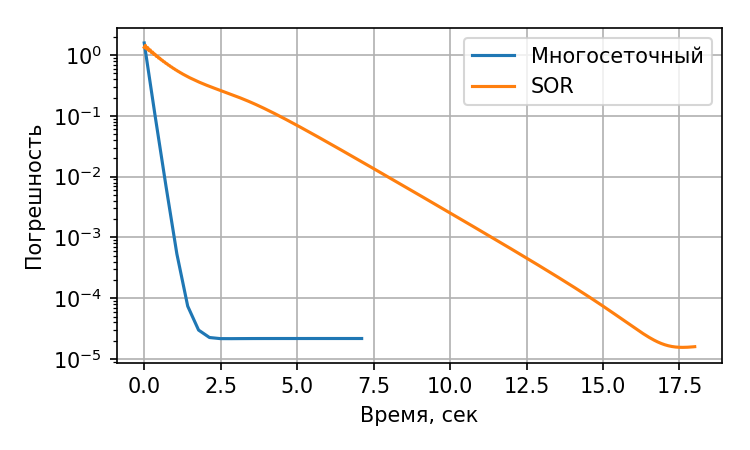

In [34]:
time_mg97 = np.linspace(0, 7.11, len(err_mg97))
time_sor97 = np.linspace(0, 18, it_sor97)
fig = plt.figure(figsize=[5,3])
plt.semilogy(time_mg97, err_mg97, label='Многосеточный')
plt.semilogy(time_sor97, err_sor97, label='SOR')
plt.xlabel('Время, сек'), plt.ylabel('Погрешность')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('compare97.png')

<IPython.core.display.Javascript object>


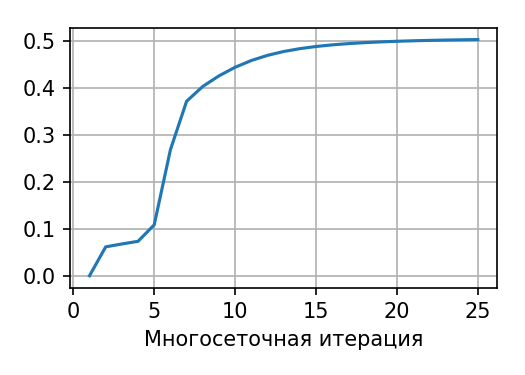

In [13]:
fig = plt.figure(figsize=[3.5,2.5])
it = np.linspace(1, len(err_mg)-1, len(sr_mg))
plt.plot(it, sr_mg)
plt.xlabel('Многосеточная итерация')
plt.grid()
plt.tight_layout()
plt.savefig('spect.png')

In [36]:
sor385_data = np.fromfile('sor385_data.npy')

In [43]:
sor385_data = sor385_data.reshape([2, int(len(sor385_data)/2)])

In [40]:
M, N = 385, 385
depth = 7
mg_it = 1
smooth_it = 2
problem = EllipticProblem(M, N, xlim, ylim)

In [41]:
%%time
sln_mg, err_mg385, sr_mg385 = problem.solve_multigrid(depth, mg_it, smooth_it, smooth_it, 
                                                      it_num=20, smooth_m='seidel')

Wall time: 1min 50s


In [44]:
sor385_data.shape

(2, 10005)

<IPython.core.display.Javascript object>


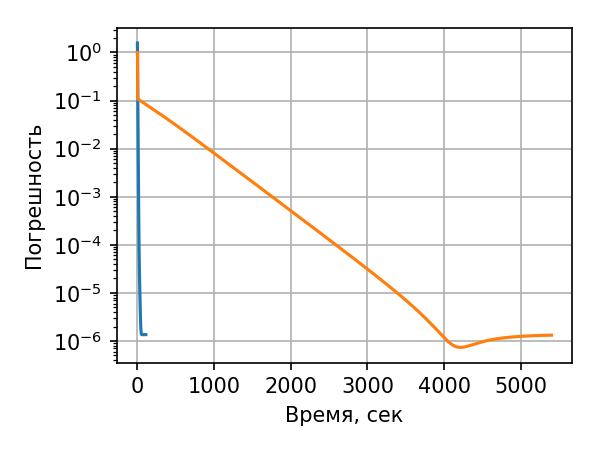

In [45]:
time_mg385 = np.linspace(0, 110, len(err_mg385))
time_sor385 = np.linspace(0, 2*45*60, sor385_data.shape[1])
fig = plt.figure(figsize=[4,3])
plt.semilogy(time_mg385, err_mg385, time_sor385, sor385_data[1,:])
plt.xlabel('Время, сек'), plt.ylabel('Погрешность')
plt.grid()
plt.tight_layout()
#plt.savefig('compare385.png')

# 6. Сопряжённые градиенты

In [10]:
M, N = 193, 193
depth = 6
mg_it = 1
smooth_it = 2

In [11]:
problem = EllipticProblem(M, N, xlim, ylim, symm=True)

In [12]:
%%time
sln_cg, err_cg = problem.solve_conj_grad(depth, mg_it, smooth_it, smooth_it, it_num=700, precond='none')

CPU times: user 2min 4s, sys: 3.91 s, total: 2min 8s
Wall time: 1min 4s


In [77]:
problem.sln = np.zeros_like(problem.sln)

In [83]:
%%time
sln_cg_prec, err_cg_prec = problem.solve_conj_grad(depth, mg_it, smooth_it, smooth_it, 
                                                   it_num=15, precond='multigrid')

CPU times: user 31.6 s, sys: 855 ms, total: 32.4 s
Wall time: 16.8 s


In [12]:
problem.sln = np.zeros_like(problem.sln)

In [13]:
%%time
sln_cg_ilu, err_cg_ilu = problem.solve_conj_grad(depth, mg_it, smooth_it, smooth_it, eps=5.6e-6, precond='ilu')

Wall time: 1min 48s


In [91]:
problem.error()

5.574571763570249e-06

In [14]:
len(err_cg_ilu)

166

<IPython.core.display.Javascript object>


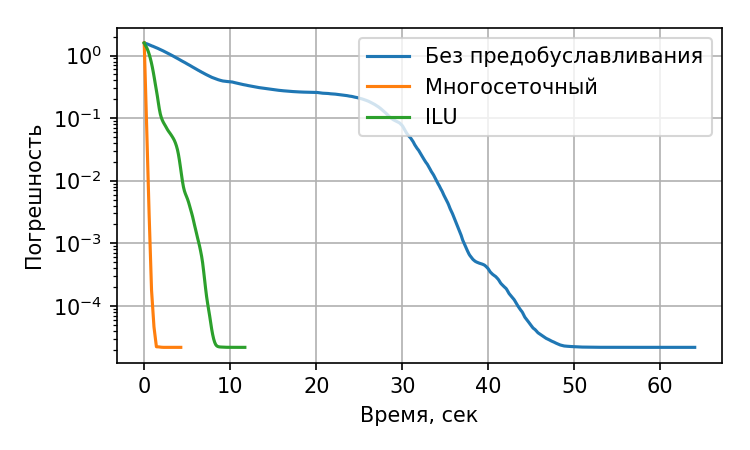

In [36]:
time_cg = np.linspace(0, 64, len(err_cg))
time_cg_prec = np.linspace(0, 4.25, len(err_cg_prec))
time_cg_ilu = np.linspace(0, 11.7, len(err_cg_ilu))
fig = plt.figure(figsize=[5,3])
plt.semilogy(time_cg, err_cg, label='Без предобуславливания')
plt.semilogy(time_cg_prec, err_cg_prec, label='Многосеточный')
plt.semilogy(time_cg_ilu, err_cg_ilu, label='ILU')
plt.xlabel('Время, сек'), plt.ylabel('Погрешность')
plt.legend(loc=1)
plt.grid()
plt.tight_layout()
plt.savefig('compare_cg97.png')

<IPython.core.display.Javascript object>


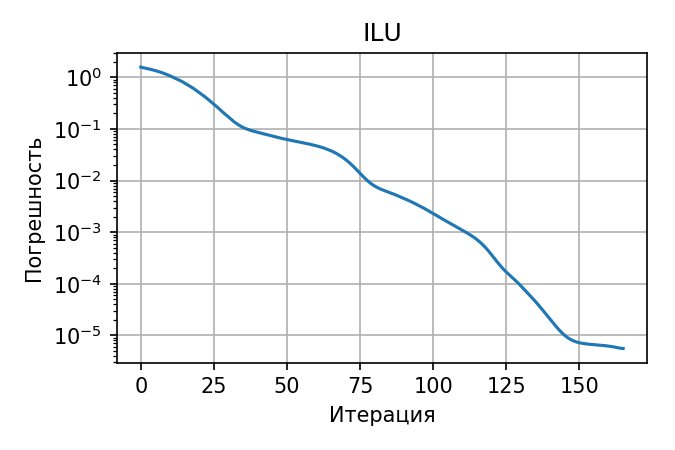

In [98]:
fig = plt.figure(figsize=[4.5,3])
plt.semilogy(err_cg_ilu)
plt.xlabel('Итерация'), plt.ylabel('Погрешность')
plt.title('ILU')
plt.grid()
plt.tight_layout()
plt.savefig('cg_ilu193.png')

<IPython.core.display.Javascript object>


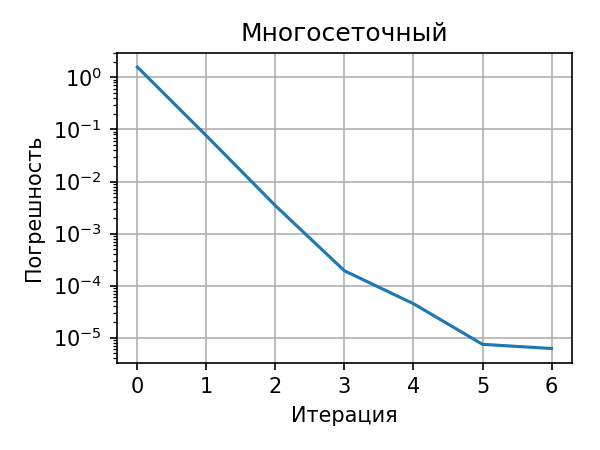

In [96]:
fig = plt.figure(figsize=[4,3])
plt.semilogy(err_cg_prec[:7])
plt.xlabel('Итерация'), plt.ylabel('Погрешность')
plt.title('Многосеточный')
plt.grid()
plt.tight_layout()
plt.savefig('cg_mg193.png')

In [15]:
err_cg_ilu[100:108]

[0.00229947735352408,
 0.002132239305295719,
 0.0019716422258666154,
 0.0018249996351941266,
 0.0016943660787591662,
 0.0015726902340233691,
 0.0014586966843242236,
 0.0013566329486206653]

# Test

In [1]:
import numpy as np
from problemlib.elliptic import *
import pandas as pd
import scipy.sparse
import scipy.sparse.linalg

In [7]:
xlim = np.array([0, np.pi])
ylim = np.array([0, np.pi])
M, N = 49, 49
prec = 5e-6
depth = 4
mg_it = 1
sm_it = 2

In [6]:
pbm = EllipticProblem(M, N, xlim, ylim, symm=True)

In [14]:
ilum, L, U = pbm.ilu()

In [46]:
np.savetxt('fm.csv', pbm.full_matrix(), fmt='%.2f')

In [9]:
pbm.solve_conj_grad(depth, mg_it, sm_it, sm_it, precond='ilu')
pbm.error()

9.505708261507715e-05

In [8]:
%precision 1

'%.1f'

In [7]:
pbm.solve_ilu(ilu_m, pbm.right) - np.linalg.solve(pbm.full_matrix(), pbm.right)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        5.17306211e-17, -6.74322232e-02, -3.24878776e-01,  2.92028604e-16,
       -4.69270294e-16, -3.85325905e-02,  6.34637836e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.22464680e-16])

In [15]:
np.linalg.norm(pbm.solve_ilu(ilum, pbm.right) - np.linalg.solve(L@U, pbm.right))

0.0

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

<IPython.core.display.Javascript object>


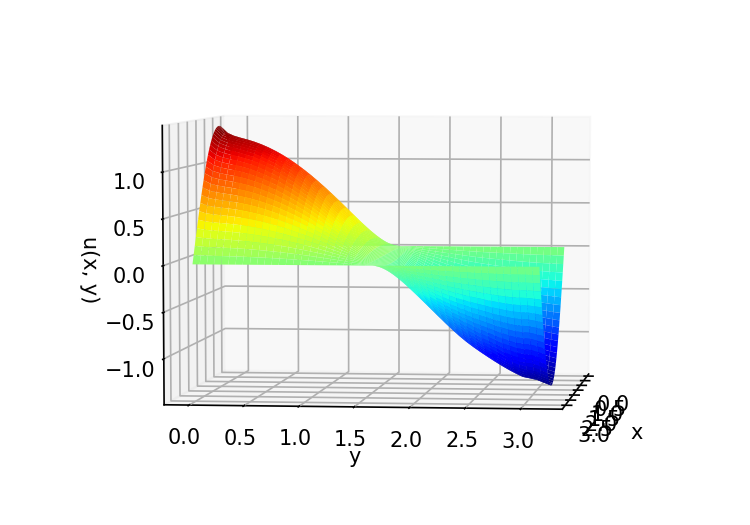

In [16]:
X, Y = np.meshgrid(pbm.mesh.X, pbm.mesh.Y)
fig = plt.figure(figsize=[5,3.5])
ax = Axes3D(fig)
ax.plot_surface(X, Y, pbm.sln_matrix(), cmap=cm.jet)
ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_zlabel('u(x, y)')
ax.dist = 11
fig.show()

In [16]:
np.linalg.norm(np.linalg.solve(pbm.full_matrix(), pbm.right) - pbm.exact_sln())

0.0009372685387335391